In [1]:
import os, sys 
import numpy as np 

IMATOOLS_DIR = os.getcwd()+'/..'
sys.path.insert(1, IMATOOLS_DIR)

from imatools.common import ioutils as iou
from imatools.common import vtktools as vtku 

def calc_cog(pts, el):
    return [np.mean(pts[ee], 0) for ee in el]

norm2 = lambda a : np.linalg.norm(a)
norm_vec = lambda a : a/norm2(a)


def extract_from_dataframe(dframe, window, bdir=None):
    _dir = dframe.result_path[window]
    _user = dframe.user[window].tolist()
    _patient = dframe.patient[window].tolist()
    _mode = dframe['mode'][window].tolist()
    _original_dir = dframe.original_path[window]
    _sim_dir = dframe.simulation_path[window]

    if (bdir is not None):
        _dir = [px.replace('$AFIB_REPROD', bdir) for px in _dir]
        _original_dir = [px.replace('$AFIB_REPROD', bdir)
                         for px in _original_dir]
        _sim_dir = [px.replace('$AFIB_REPROD', bdir) for px in _sim_dir]
    else:
       _dir = _dir.tolist()
       _sim_dir = _sim_dir.tolist()
       _original_dir = _original_dir.tolist()

    return _dir, _user, _patient, _mode, _original_dir, _sim_dir

LABEL_STR = ['FULL', 'LA', 'LSPV', 'LIPV', 'RSPV', 'RIPV', 'LAA']
LABEL_LIST = [0, 1, 11, 13, 15, 17, 19]

In [2]:
# Locations of hard drive based on platform
dirdic = {'macOS': '/Volumes/sandisk',
          'Linux': '/media/jsl19/sandisk',
          'Windows': 'D:/'}

tex_dic = {'macOS' : '/Users/jsolislemus/Documents/TEX', 
            'Linux' : '/home/jsl19/Documents/tex'}

base_dir = iou.fullfile(dirdic[iou.chooseplatform()], '01_atrialfibres/06_Reproducibility/05_UserProjects')
sims_dir = iou.fullfile(base_dir, '008_simulation_results')
out_dir = iou.fullfile(base_dir, '009_simulation_images', 'Fibre_Agreement')

tex_dir = iou.fullfile(tex_dic[iou.chooseplatform()], 'tex.cinbio.reproducibility/scripts/py')

N = ['M' + str(n) for n in np.linspace(1,100,num=100, dtype=int)]

Loading `simulation_paths.csv`, which contains the original paths and the result paths of everything. This is useful for comparisons.

In [3]:
import pandas as pd 

df = pd.read_csv(iou.fullfile(base_dir, 'simulations_paths.csv'))
num_pairs = int(len(df)/2)

df

,ID,original_path,simulation_path,result_path,user,patient,mode,processing
0,M001,$AFIB_REPROD/002_charlie/03_completed/PATIENT_...,$AFIB_REPROD/007_simulations/M001,$AFIB_REPROD/008_simulation_results/M1,002_charlie,PATIENT_1877870,inter,manual
1,M002,$AFIB_REPROD/003_rosie/03_completed/PATIENT_18...,$AFIB_REPROD/007_simulations/M002,$AFIB_REPROD/008_simulation_results/M2,003_rosie,PATIENT_1877870,inter,automatic
2,M003,$AFIB_REPROD/002_charlie/03_completed/PATIENT_...,$AFIB_REPROD/007_simulations/M003,$AFIB_REPROD/008_simulation_results/M3,002_charlie,PATIENT_2540680,inter,automatic
3,M004,$AFIB_REPROD/004_jose/03_completed/PATIENT_254...,$AFIB_REPROD/007_simulations/M004,$AFIB_REPROD/008_simulation_results/M4,004_jose,PATIENT_2540680,inter,automatic
4,M005,$AFIB_REPROD/002_charlie/03_completed/PATIENT_...,$AFIB_REPROD/007_simulations/M005,$AFIB_REPROD/008_simulation_results/M5,002_charlie,PATIENT_3506490,inter,automatic
...,...,...,...,...,...,...,...,...
95,M096,$AFIB_REPROD/004_jose/03_completed/PATIENT_681...,$AFIB_REPROD/007_simulations/M096,$AFIB_REPROD/008_simulation_results/M96,004_jose,PATIENT_6816821,intra,automatic
96,M097,$AFIB_REPROD/004_jose/03_completed/PATIENT_148...,$AFIB_REPROD/007_simulations/M097,$AFIB_REPROD/008_simulation_results/M97,004_jose,PATIENT_1485560,intra,automatic
97,M098,$AFIB_REPROD/004_jose/03_completed/PATIENT_148...,$AFIB_REPROD/007_simulations/M098,$AFIB_REPROD/008_simulation_results/M98,004_jose,PATIENT_1485561,intra,automatic
98,M099,$AFIB_REPROD/004_jose/03_completed/PATIENT_132...,$AFIB_REPROD/007_simulations/M099,$AFIB_REPROD/008_simulation_results/M99,004_jose,PATIENT_1321410,intra,automatic


Extract relevant information from the dataframe

In [18]:
import vtk 

win_a = np.linspace(0,98,num=50,dtype=int)
win_b = np.linspace(1,99,num=50,dtype=int)

dir_a, user_a, patient_a, mode_a, odir_a, _ = extract_from_dataframe(df, window=win_a, bdir=base_dir)
dir_b, user_b, patient_b, mode_b, odir_b, _ = extract_from_dataframe(df, window=win_b, bdir=base_dir)

fibre_file = 'l' 
mname = 'Bilayer_' + fibre_file



# Sanity checks on fibre files
Checking that meshes and fibre fields are the same, even though they have been processed in three different occasions: 
+ **Model Rep study (OG)** by users (`cemrg/uac:v1.1`).
+ **Batch processed (007)** by JASL (`cemrg/uac:v2.0`)
+ **Batch processed (008)** by CR (same build as `cemrg/uac:v3.0-alpha`). Simulations were run here.

> **EDIT:** It seems that 007 was created with a newer version of cemrg/uac, closer to `v3.0-alpha`

In [19]:
import numpy as np 

l2_norm = lambda a : np.linalg.norm(a, axis=1)

ix = 0 # select index to compare 

res_dir, _, _, _, og_dir, sim_dir = extract_from_dataframe(dframe=df, window=[ix], bdir=base_dir)
res_dir = res_dir[0]
og_dir = og_dir[0]
sim_dir = sim_dir[0]

res_fibre = 'Bilayer_1'
og_fibre = 'Bilayer'
sim_fibre = 'FF1_Bilayer'

exts = {'points': '.pts', 'elements': '.elem', 'fibres' : '.lon'}

pts_res, el_res, _ = iou.loadCarpMesh(res_fibre, res_dir)
pts_og, el_og, _ = iou.loadCarpMesh(og_fibre, og_dir)

print('Pts: {}'.format(np.mean(l2_norm(pts_res-pts_og))))
print('Elems: {}'.format(np.mean(l2_norm(np.array(el_res)-np.array(el_og)))))


[INFO] Number of elements: 688369
[INFO] Number of elements: 688369
Pts: 2.1135667421462063e-08
Elems: 0.0


In [20]:

fib_res = np.loadtxt(iou.fullfile(res_dir, res_fibre+exts['fibres']))
fib_og = np.loadtxt(iou.fullfile(og_dir, og_fibre+exts['fibres']))
fib_sim = np.loadtxt(iou.fullfile(sim_dir, sim_fibre+exts['fibres']))

print('Comparison 008 vs OG : {}'.format(np.mean(l2_norm(fib_res - fib_og))))
print('Comparison 008 vs 007: {}'.format(np.mean(l2_norm(fib_res - fib_sim))))


Comparison 008 vs OG : 0.9738682077383437
Comparison 008 vs 007: 5.9573014159555046e-05


0.0014527092300786351

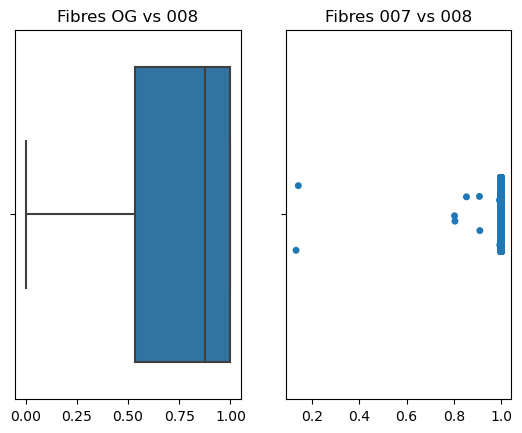

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

adot_res_vs_og = np.abs(np.sum(fib_res*fib_og, axis=1))
adot_res_vs_sim = np.abs(np.sum(fib_res*fib_sim, axis=1))

fig, axes = plt.subplots(1,2)
axes[0].set_title('Fibres OG vs 008')
axes[1].set_title('Fibres 007 vs 008')

sns.boxplot(ax=axes[0], x=adot_res_vs_og)
sns.stripplot(ax=axes[1], x=adot_res_vs_sim)

100*np.sum(adot_res_vs_sim<0.99999)/len(adot_res_vs_sim)

In [ ]:
cases = [9, 20, 35, 71, 80]
test_008, _, _, test_mode, test_OG, test_007 = extract_from_dataframe(dframe=df, window=cases, bdir=base_dir)

run_in_os = False

print(df.iloc[cases]['ID'])

for ix in range(len(test_OG)) : 
    print('cp -r {} {}'.format(test_OG[ix], iou.fullfile(base_dir, '010_consistency_tests', 'M'+str(cases[ix]+1)))) 
    if run_in_os : 
        os.system('cp -r {} {}'.format(test_OG[ix], iou.fullfile(base_dir, '010_consistency_tests', 'M'+str(cases[ix]+1)))) 


# Consistency tests
Start here to load and set variables. 



In [9]:
cases = [9, 20, 35, 71, 80]
test_008, _, _, _, _, test_007 = extract_from_dataframe(
    dframe=df, window=cases, bdir=base_dir)

test_010 = [l.replace('008_simulation_results', '010_consistency_tests') for l in test_008]

fibre_name_010 = 'Bilayer'
fibre_name_007 = 'FF1_Bilayer'
fibre_name_008 = 'Bilayer_1'

cx = 0

# print(iou.fullfile(test_010[cx], fibre_name_010))

pts007, el007, _ = iou.loadCarpMesh(fibre_name_007, test_007[cx])
pts010, el010, _ = iou.loadCarpMesh(fibre_name_010, test_010[cx])

pts_mean_l2,el_mean_l2,c = iou.compareCarpMesh(pts1=pts007, el1=el007, pts2=pts010, el2=el010)

print('[007 vs 010] Pts: {}, El: {}'.format(pts_mean_l2, el_mean_l2))

pts008, el008, _ = iou.loadCarpMesh(fibre_name_008, test_008[cx])

pts_mean_l2,el_mean_l2,c = iou.compareCarpMesh(pts1=pts008, el1=el008, pts2=pts010, el2=el010)
print('[008 vs 010] Pts: {}, El: {}'.format(pts_mean_l2, el_mean_l2))

[INFO] Number of elements: 710430
[INFO] Number of elements: 710430
[007 vs 010] Pts: 2.19092453906399e-08, El: 0.0
[INFO] Number of elements: 710430
[008 vs 010] Pts: 2.19092453906399e-08, El: 0.0


Continue here to load the fibre files and calculate the absolute value of the dot product between the files

[7vs10] Fibres with abs_dot higher than [0.9]: 374407 / 710430
[8vs10] Fibres with abs_dot higher than [0.9]: 374408 / 710430


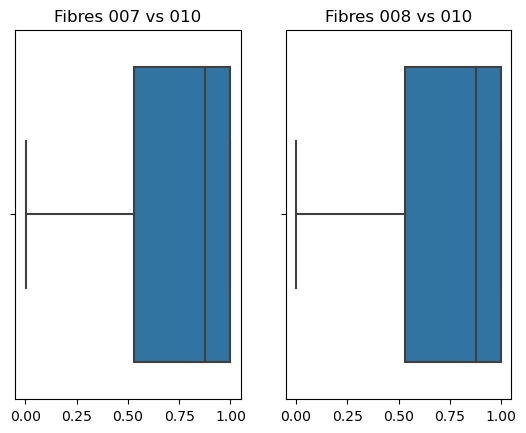

In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

exts = {'points': '.pts', 'elements': '.elem', 'fibres' : '.lon'}

fib007 = np.loadtxt(iou.fullfile(test_007[cx], fibre_name_007 + exts['fibres']))
fib008 = np.loadtxt(iou.fullfile(test_008[cx], fibre_name_008 + exts['fibres']))
fib010 = np.loadtxt(iou.fullfile(test_010[cx], fibre_name_010 + exts['fibres']))

adot_7_vs_10 = np.abs(iou.dot_prod_vec(fib007, fib010))
adot_8_vs_10 = np.abs(iou.dot_prod_vec(fib008, fib010))



[7vs10] Fibres with abs_dot higher than [0.75]: 433839 / 710430
[8vs10] Fibres with abs_dot higher than [0.75]: 433836 / 710430


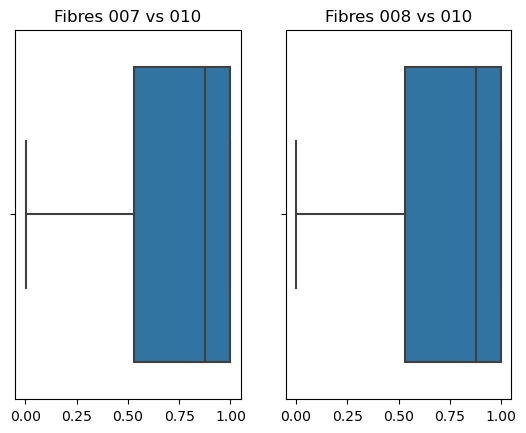

In [16]:

fig, axes = plt.subplots(1,2)
axes[0].set_title('Fibres 007 vs 010')
axes[1].set_title('Fibres 008 vs 010')
sns.boxplot(ax=axes[0], x=adot_7_vs_10)
sns.boxplot(ax=axes[1], x=adot_8_vs_10)

th=0.75
print('[7vs10] Fibres with abs_dot higher than [{}]: {} / {}'.format(th, np.sum(adot_7_vs_10 > th), len(adot_7_vs_10)))
print('[8vs10] Fibres with abs_dot higher than [{}]: {} / {}'.format(th, np.sum(adot_8_vs_10 > th), len(adot_8_vs_10)))


# FIBRE AGREEMENT COMPARISONS
This recreates the comparisons between fibre fields for the comparisons 
+ Inter - User A vs User B
+ Intra - Patient A vs Patient A

In [ ]:

ix=1

u0 = user_a[ix] 
u1 = user_b[ix]
p0 = patient_a[ix] 
p1 = patient_b[ix]

iou.cout('{}: U0[{}] vs U1[{}]'.format(ix, u0, u1), typeMsg='PROCESSING')

patient = p0 if(mode_a[ix] == 'inter') else p0[0:-2]

mesh_a = vtku.readVtk(iou.fullfile(dir_a[ix], mname + '.vtk'))
mesh_b = vtku.readVtk(iou.fullfile(dir_b[ix], mname + '.vtk'))

fib_a = np.loadtxt(iou.fullfile(dir_a[ix], mname + '.lon'))
fib_b = np.loadtxt(iou.fullfile(dir_b[ix], mname + '.lon'))



# fib_comparison = vtku.compare_fibres(msh_a=mesh_a, msh_b=mesh_b, f_a=fib_a, f_b=fib_b)

In [ ]:
for ix in range(1) : 
    u0 = user_a[ix] 
    u1 = user_b[ix]
    p0 = patient_a[ix] 
    p1 = patient_b[ix]
    iou.cout('{}: U0[{}] vs U1[{}]'.format(ix, u0, u1), typeMsg='PROCESSING')

    patient = p0 if(mode_a[ix] == 'inter') else p0[0:-2]
    
    path_left = dir_a[ix]
    tot_left = iou.getTotal(iou.fullfile(path_left, mname+'.pts'))

    path_right = dir_b[ix]
    tot_right = iou.getTotal(iou.fullfile(path_right, mname + '.pts'))

    path0=path_left 
    path1=path_right 
    if tot_left < tot_right : 
        path0=path_right
        path1=path_left
    
    pts1, el1, region1 = iou.loadCarpMesh(mname, path1)
    pts1 /= 1000 
    cog1 = calc_cog(pts1, el1)

    f0 = np.loadtxt(iou.fullfile(path0, mname+'.lon'))
    f1 = np.loadtxt(iou.fullfile(path1, mname+'.lon'))

    pts0, el0, region0 = iou.loadCarpMesh(mname, path0)
    pts0 /= 1000 

    vtku.saveCarpAsVtk(pts0, el0, path0, mname)
    
    l0 = iou.fullfile(path0,mname+'.vtk')
    msh0 = vtku.readVtk(iou.fullfile(l0))

    cell_loc=vtk.vtkCellLocator()
    cell_loc.SetDataSet(msh0)
    cell_loc.BuildLocator()

    nel1 = len(el1)
    f0v1_dot = np.zeros(nel1)
    f0v1_dist = np.zeros(nel1)

    for jx in range(nel1):
        cellId = vtk.reference(0)
        c = [0.0, 0.0, 0.0]
        subId = vtk.reference(0)
        d = vtk.reference(0.0)

        cell_loc.FindClosestPoint(cog1[jx], c, cellId, subId, d)
        f0v1_dist[jx] = norm2(cog1[jx] - c)
        a=norm_vec(f0[cellId.get()])
        b=norm_vec(f1[jx])
        f0v1_dot[jx] = np.dot(a,b)

    f0v1_angles = np.arccos(f0v1_dot)
    f0v1_abs_dot = np.abs(f0v1_dot)
    f0v1_angle_abs_dot = np.arccos(f0v1_abs_dot)

    d={'region' : region1,
        'dot_product' : f0v1_dot,
        'angle' : f0v1_angles,
        'distance_to_point' : f0v1_dist,
        'abs_dot_product' : f0v1_abs_dot,
        'angle_from_absdot' : f0v1_angle_abs_dot}

    out_name = "fibres_agree_" + fibre_file + '_' + mode_a[ix] + "_" + patient + ".csv"
    out_df = pd.DataFrame(data=d)
    out_df.to_csv(iou.fullfile(out_dir, out_name))



In [ ]:

print(np.divide(f0.T*2,np.linalg.norm(f0*2, axis=1)).T)